<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Captioning" data-toc-modified-id="Image-Captioning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Captioning</a></span><ul class="toc-item"><li><span><a href="#Preprocess" data-toc-modified-id="Preprocess-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocess</a></span><ul class="toc-item"><li><span><a href="#Prepare-Photo-Data-(extract-features)" data-toc-modified-id="Prepare-Photo-Data-(extract-features)-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Photo Data (extract features)</a></span></li><li><span><a href="#Prepare-Text-Data" data-toc-modified-id="Prepare-Text-Data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Prepare Text Data</a></span></li></ul></li><li><span><a href="#Develop-Model" data-toc-modified-id="Develop-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Develop Model</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></li><li><span><a href="#Generate-New-Captions" data-toc-modified-id="Generate-New-Captions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Generate New Captions</a></span></li></ul></li><li><span><a href="#Language-Model" data-toc-modified-id="Language-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Language Model</a></span></li></ul></div>

In [3]:
import string
from os import listdir
from numpy import array
from pickle import dump, load
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras import optimizers
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Image Captioning

## Preprocess

### Prepare Photo Data (extract features)

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    
    return features

In [ ]:
# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

### Prepare Text Data

In [ ]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

In [ ]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

## Develop Model

### Load Data

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
    # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [3]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [4]:
def create_sequences_all(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [5]:
# create sequences of images, input sequences and output words for a batch worth of data for single image
def create_sequences_single(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [6]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [7]:
# define the captioning model
def define_model(vocab_size, max_length, lr=0.001):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam)
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [8]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator_batch(descriptions, photos, tokenizer, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            # retrieve the photo feature
            for desc in desc_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photos[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

In [9]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences_single(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]

In [10]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
#X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [11]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences_all(tokenizer, max_length, test_descriptions, test_features)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [16]:
# define the model
model = define_model(vocab_size, max_length, lr=0.0001)
#model = load_model('model-20-3.8115.hdf5')

checkpointer = ModelCheckpoint(filepath="model-{epoch:02d}-{val_loss:.4f}.hdf5",monitor='val_loss', verbose=1, save_best_only=True,mode='min')
# train the model, run epochs manually and save after each epoch

steps = len(train_descriptions)//6
#generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
generator = data_generator_batch(train_descriptions, train_features, tokenizer, max_length, batch_size=16)
model.fit_generator(generator, epochs=20,callbacks=[checkpointer], validation_data=([X1test, X2test], ytest), steps_per_epoch=steps, verbose=1,initial_epoch=0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

KeyboardInterrupt: 

### Evaluate Model

In [10]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [11]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [12]:
# Run 4
model = load_model('model-12-3.8330.hdf5')
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

OSError: Unable to open file (unable to open file: name = 'model-12-3.8330.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [44]:
# Run 5
model = load_model('model-04-3.7182.hdf5')
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.546376
BLEU-2: 0.319651
BLEU-3: 0.232671
BLEU-4: 0.121039


In [22]:
# Run 7
model = load_model('model-20-3.8736.hdf5')
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.516067
BLEU-2: 0.323058
BLEU-3: 0.237691
BLEU-4: 0.123128


In [14]:
# Run 8
model = load_model('model-30-3.7886.hdf5')
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.568993
BLEU-2: 0.344422
BLEU-3: 0.252795
BLEU-4: 0.134496


In [17]:
# Run 9
model = load_model('run9_20e_6b */model-11-3.7910.hdf5')
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.583208
BLEU-2: 0.349395
BLEU-3: 0.255938
BLEU-4: 0.135524


## Generate New Captions

In [4]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature
 
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)        
    return final

In [ ]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('run9_20e_6b/model-11-3.7910.hdf5')
# load and prepare the photograph
photo = extract_features('example.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [19]:
import matplotlib.pyplot as plt 
from IPython.display import Image, display
import glob
import numpy as np

def process(filename):
    display(Image(filename=filename))

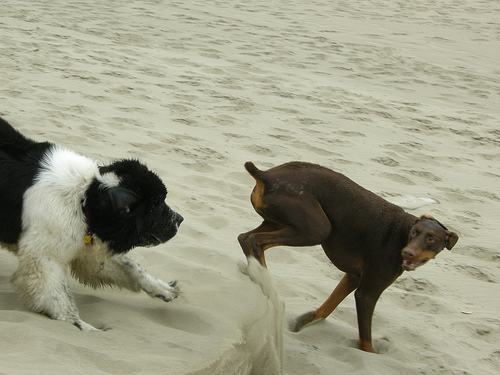

placemats dog is running on the beach


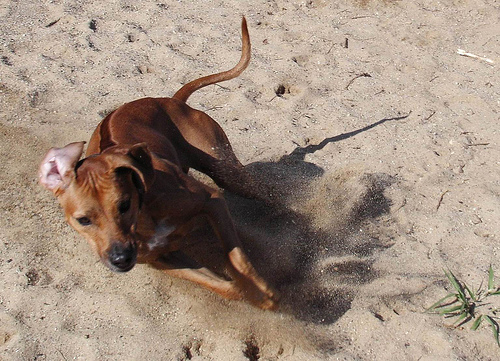

brown dog is running on the sand


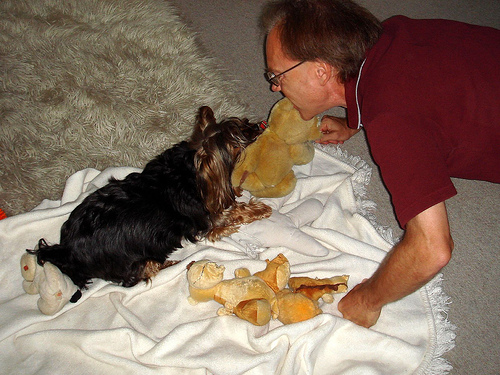

man with white dog is playing with white dog


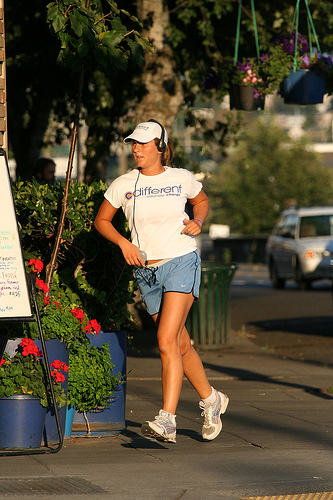

woman in jumphouse and white shirt is standing on sidewalk


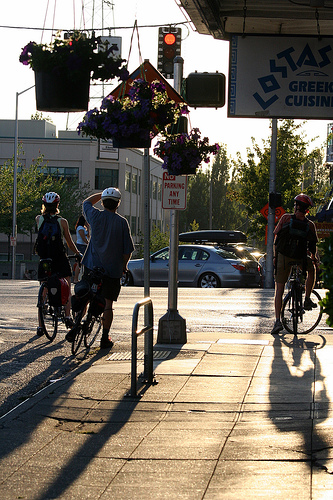

people are riding trick on the intersection


In [20]:
files = glob.glob('pics/*.jpg')
random_files = np.random.choice(files, 5)
model = load_model('run9_20e_6b/model-11-3.7910.hdf5')
tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

    
for pic in random_files:
    # load and prepare the photograph
    process(pic)
    photo = extract_features(pic)
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    print(description)

# Language Model

In [24]:
!git clone https://github.com/graykode/gpt-2-Pytorch
%cd gpt-2-Pytorch
!curl --output gpt2-pytorch_model.bin https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin
!pip install -r requirements.txt

Cloning into 'gpt-2-Pytorch'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 83 (delta 34), reused 83 (delta 34), pack-reused 0
Unpacking objects: 100% (83/83), done.
/home/jupyter/Projects/opticfable/gpt-2-Pytorch/gpt-2-Pytorch
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  522M  100  522M    0     0  4655k      0  0:01:54  0:01:54 --:--:-- 5405k


In [34]:
!python main.py --text "brown dog is running on the sand"

Traceback (most recent call last):
  File "main.py", line 12, in <module>
    from GPT2.model import (GPT2LMHeadModel)
ImportError: No module named GPT2.model


In [33]:
from GPT2.model import (GPT2LMHeadModel)